In [67]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os 

In [68]:
num_classes = 5
batch_size = 8
num_epochs = 2
image_size = (224,224)
# ADD DATASET FROM DIRECTORY

data_dir = r"/mnt/c/Windows/System32/repos/thesis_raw_data/Doc_H-Data"

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  labels='inferred',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size= image_size,
  batch_size= batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  labels='inferred',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size= image_size,
  batch_size= batch_size)

train_dataset = val_ds.take(5)
val_ds = val_ds.skip(5)

print('Batches for testing -->', train_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())


Found 390 files belonging to 5 classes.
Using 312 files for training.
Found 390 files belonging to 5 classes.
Using 78 files for validation.
Batches for testing --> tf.Tensor(39, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(5, shape=(), dtype=int64)


In [69]:
# train_ds_ub = train_ds.unbatch()
# images = list(train_ds_ub.map(lambda x, y: x))
# labels = list(train_ds_ub.map(lambda x, y: y))

# print(labels)

y = np.concatenate([y for x, y in train_ds], axis=0)
print(y)

2023-05-19 01:26:54.985397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [312]
	 [[{{node Placeholder/_4}}]]
2023-05-19 01:26:54.985667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [312]
	 [[{{node Placeholder/_0}}]]


[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [70]:
vgg16_model = VGG16(include_top = False,
            weights = 'imagenet', 
            input_tensor = None, 
            input_shape = (224,224,3), #shape of npy file data
            pooling = None,
            classes = 1000,
            classifier_activation="softmax") 


# Do not retrain convolutional layers
for layer in vgg16_model.layers:
    layer.trainable = False

input_shape = keras.Input(shape=(224, 224, 3))

# Add new fully connected layers
x = Flatten()(vgg16_model.output)
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # num_classes is the number of classes in your dataset

# Create a new model with the fully connected layers added
model = Model(inputs=vgg16_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
# Use the generators to train the model
history = model.fit(train_ds,
          validation_data = val_ds,
          epochs=num_epochs,
          )
        #   steps_per_epoch= len(train_generator) // batch_size,
        #   validation_data=test_generator)


Epoch 1/2
39/39 [==============================] - ETA: 0s - loss: 41.2832 - accuracy: 0.4038

2023-05-19 01:27:03.965414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [78]
	 [[{{node Placeholder/_4}}]]
2023-05-19 01:27:03.965731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [78]
	 [[{{node Placeholder/_4}}]]


39/39 [==============================] - 10s 166ms/step - loss: 41.2832 - accuracy: 0.4038 - val_loss: 2.7981 - val_accuracy: 0.6053
Epoch 2/2
39/39 [==============================] - 5s 106ms/step - loss: 3.9100 - accuracy: 0.7564 - val_loss: 9.7120 - val_accuracy: 0.4211


[0.6052631735801697, 0.42105263471603394]


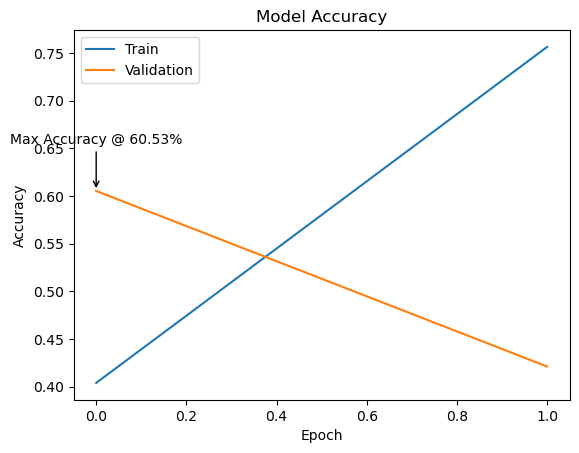

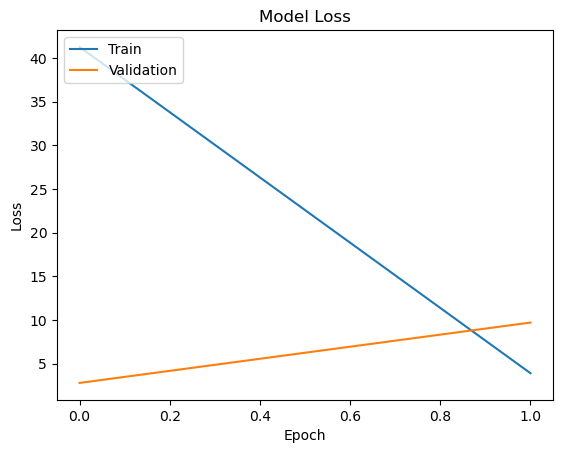

In [72]:

# Save the trained model
model.save('vgg16_trained.h5')

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

print(history.history['val_accuracy'])
#Find the x and y position of the highest test accuracy
#list all val_accuracy values
list = history.history['val_accuracy']

#find highest val_accuracy
ymax =  max(history.history['val_accuracy'])

#find index of highest val_accuracy
xpos = list.index(max(history.history['val_accuracy']))

# Annotation for max accuracy
plt.annotate('Max Accuracy @ {}%'.format(round(ymax*100,2)), xy=(xpos, ymax), xytext=(xpos, ymax+.05), ha = 'center', 
             arrowprops=dict(arrowstyle="->", facecolor='black'))
#Show plot             
plt.show()
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

[0.6052631735801697, 0.42105263471603394]


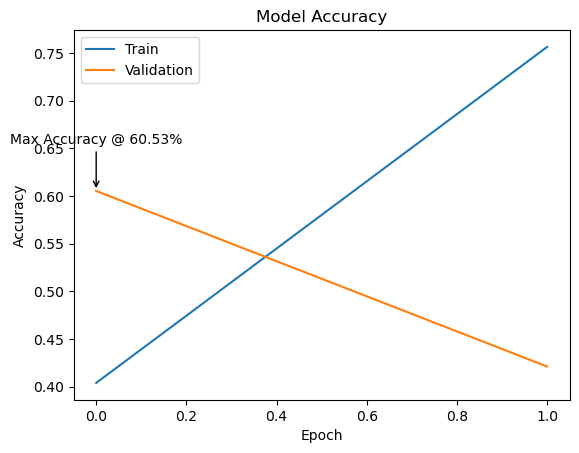

In [73]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

print(history.history['val_accuracy'])
#Find the x and y position of the highest test accuracy
#list all val_accuracy values
list = history.history['val_accuracy']

#find highest val_accuracy
ymax =  max(history.history['val_accuracy'])

#find index of highest val_accuracy
xpos = list.index(max(history.history['val_accuracy']))

# Annotation for max accuracy
plt.annotate('Max Accuracy @ {}%'.format(round(ymax*100,2)), xy=(xpos, ymax), xytext=(xpos, ymax+.05), ha = 'center', 
             arrowprops=dict(arrowstyle="->", facecolor='black'))
#Show plot             
plt.show()

https://stackoverflow.com/questions/54589669/confusion-matrix-error-classification-metrics-cant-handle-a-mix-of-multilabel\
for below

In [74]:
predicted_batch = model.predict(val_ds)
predicted_id= np.argmax(predicted_batch, axis=-1)

print(predicted_id)

true_id = tf.concat([y for x, y in val_ds], axis=0)
true_id=np.argmax(true_id, axis=1)
true_id[1]
print(true_id)


5/5 [==============================] - 2s 123ms/step
[0 0 0 0 0 0 2 0 0 0 0 0 2 1 0 0 0 1 0 0 0 1 3 0 0 0 3 0 3 2 0 0 2 1 0 0 0
 0]
[1 0 0 3 0 2 0 0 0 3 4 0 3 4 4 0 4 1 0 0 4 4 3 4 2 0 0 1 4 0 0 1 0 2 3 2 0
 0]


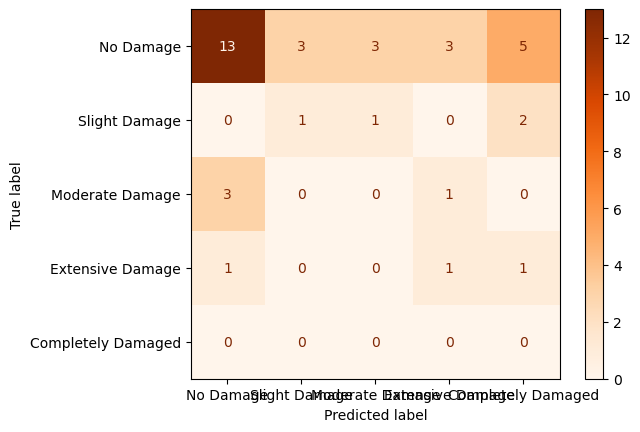

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(predicted_id, true_id)
labels = ["No Damage", "Slight Damage", "Moderate Damage", "Extensive Damage", "Completely Damaged"]
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()
